# **Real-Time Football Players Tracking**
- Team 9

## Introduction

### Project Overview
Multi-object tracking (MOT) has been a fundamental computer vision task for recent decades, aiming to locate objects and associate them in video sequences. Researchers have cast much focus on various practical use cases like crowded street scenes [1], static dancing scenes [2], and driving scenarios [3], achieving considerable progress in MOT.   

Despite these advancements, the application of MOT in sports analytics, particularly for tracking players in dynamic and cluttered sports scenes, has not been explored extensively. This oversight is notable given the potential benefits of MOT in analyzing sports footage where accurately tracking players on the field can yield valuable insights. For instance, by identifying and tracking players, it is possible to calculate metrics such as running distances, average speeds, and even conduct automatic tactical analysis, all of which are critical for enhancing team performance and strategy formulation.  

In response to this gap, our project introduces a specialized dataset focused on sports scenes, termed "SportsMOT". Our approach combines multi-object detection with advanced tracking algorithms to engineer a system specifically optimized for tracking football players. This dual-model framework not only recognizes and locates players but also maintains consistent tracking of each player across frames. Our system is designed to navigate the unique challenges of football matches, such as rapid player movements and frequent visual obstructions. By doing so, we seek to offer a solution for analyzing sports scenes through MOT, tailored to the fast-paced and complex environment of football games.

### Project Illustration


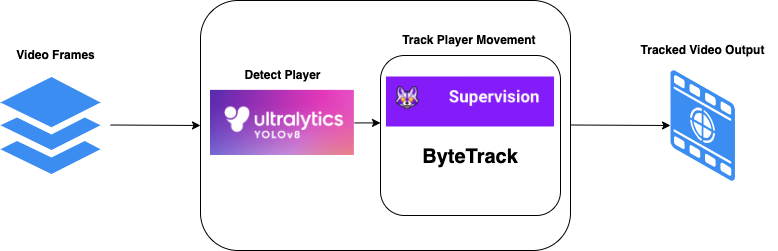

Our system processes video by breaking it down into individual frames. These frames serves as the input to our MOT system, which comprises two primary stages: detection and tracking.   
Each frame is first passed through the YOLOv8 model, this model is designed to identify and locate the players on the football field. For every player detected in the frame, YOLOv8 outputs a bounding box that outlines the player's position.  
The detected players, now marked by bounding boxes, are handed over to the ByteTrack algorithm. The tracking system uses the positional information provided by YOLOv8 to following each player's movement across the subsequent frames.   
The output of our system is the video or the sequence of frames with players consistently tracked across the football game's duration.

### Final Output



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/A_project_yolov8/progress_report/Final\ Results

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/A_project_yolov8/progress_report/Final Results


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/A_project_yolov8/progress_report/Final Results


## Data Overview


### Data Loading

#### Train and Validation Dataset
We sourced our training and validation datasets, from the public repository available at [CodaLab](https://codalab.lisn.upsaclay.fr/competitions/12424#participate). The repository offers a diverse selection of 240 labeled video frames spanning across three sports: football, volleyball, and basketball. These frames were sourced from high-profile events such as the Olympic Games, the NCAA Championship, and NBA games, all of which are available on YouTube. The videos have been manually segmented into clips for ease of use. On average, these clips contain 485 frames each, meticulously selected to ensure the absence of any shot changes. For the purpose of our study, we selectively utilized 10 video frames from the football category for training and 2 video frames for validation.

#### Test Video Clips
Our model's performance was evaluated using test footage obtained from the video clips in the Kaggle competition, avaible at [Kaggle Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout). We utilized the provided '.mp4' video files as test data.

In [ ]:
!pip install kaggle --upgrade --quiet


In [ ]:
import os
from getpass import getpass

In [ ]:
os.environ['KAGGLE_USERNAME'] = getpass('Enter KAGGLE_USERNAME secret value: ')
os.environ['KAGGLE_KEY'] = getpass('Enter KAGGLE_KEY secret value: ')

In [ ]:
!kaggle competitions files -c dfl-bundesliga-data-shootout | grep train | head -3

train/cfbe2e94_1.mp4     3GB  2022-07-29 14:23:09  
train/4ffd5986_0.mp4     3GB  2022-07-29 14:23:09  
train/1606b0e6_0.mp4     2GB  2022-07-29 14:23:09  


In [ ]:
%cd {HOME}
!kaggle competitions files -c dfl-bundesliga-data-shootout | \
grep clips | head -5 | \
awk '{print $1}' | \
while read -r line; \
  do kaggle competitions download -c dfl-bundesliga-data-shootout -f $line -p clips --quiet; \
  unzip ${line}.zip -d clips && rm ${line}.zip; \
  done

### Data Processing
The original dataset was formatted for MOT tasks, with annotations provided in **'.gt'** files. These files contain metadata for each frame, detailing object positions and tracking information in the form of **[frame_id, track_id, x, y, w, h]**.

To adapt this dataset for use with YOLOv8, which requires annotations in a different format **[track_id, x_min, y_min, x_max, y_max]**, we embarked on a process to convert the existing data:


1.   **Annotation Transformation**: We developed a script to convert **'.gt'** files into the format required by YOLOv8, which is typically a **'.txt'** file for each image with bounding box coordiates and class identifiers.

2.  **Compatibility and Verification**: The conversion script adjust the coordinates to fit the image dimensions specified by YOLOv8, and maps class identifiers to meet the model's expectation. We then uploaded the image along and their converted label to Roboflow for verification, ensuring that the transformed data maintained its integrity and accurately reflected the original annotations.

In [ ]:
import os
import shutil

import cv2
import numpy as np
from tqdm import tqdm


SRC_DIR = "/Users/ruby/Desktop/football_dataset"
OUT_DIR = "/Users/ruby/Desktop/football_dataset/YOLO"
SPLITS = ["train", "val"]

os.makedirs(OUT_DIR, exist_ok=True)

def mot_to_yolo():
  for split in SPLITS:
      # Create directory
      out_path = os.path.join(OUT_DIR, split)
      out_image_path = os.path.join(out_path, "images")
      out_label_path = os.path.join(out_path, "labels")

      os.makedirs(out_image_path, exist_ok=True)
      if split != "test":
          os.makedirs(out_label_path, exist_ok=True)

      seq_path = os.path.join(SRC_DIR, split)
      seq_list = os.listdir(seq_path)

      # transfer images and create labels
      for seq in tqdm(seq_list):
          if '.DS_Store' in seq:
              continue

          img_path = os.path.join(seq_path, seq, "img1")

          for img_file in os.listdir(img_path):
              new_img_name = f"{seq}_{img_file}"
              shutil.copy(os.path.join(img_path, img_file),
                          os.path.join(out_image_path, new_img_name))

          if split == "test":
              continue

          ann_file = os.path.join(seq_path, seq, "gt", "gt.txt")
          anns = np.loadtxt(ann_file, delimiter=',')
          for frame_id in np.unique(anns[:, 0]):
              frame_anns = anns[anns[:, 0] == frame_id]
              yolo_labels = []

              for ann in frame_anns:
                  bbox = ann[2:6]
                  img_name = f"{int(frame_id):06d}.jpg"
                  new_img_name = f"{seq}_{img_name}"
                  img_path = os.path.join(out_image_path, new_img_name)
                  img = cv2.imread(img_path)
                  h, w = img.shape[:2]
                  x_center = (bbox[0] + bbox[2] / 2) / w
                  y_center = (bbox[1] + bbox[3] / 2) / h
                  width = bbox[2] / w
                  height = bbox[3] / h
                  class_id = 0
                  yolo_labels.append(
                      f"{class_id} {x_center} {y_center} {width} {height}")

              label_file_name = f"{seq}_{int(frame_id):06d}.txt"
              label_file_path = os.path.join(out_label_path, label_file_name)
              with open(label_file_path, 'w') as f:
                  f.write("\n".join(yolo_labels))

mot_to_yolo()

### Data Visualization
To confirm the success of our data conversion, we visualized the annotations after the conversion

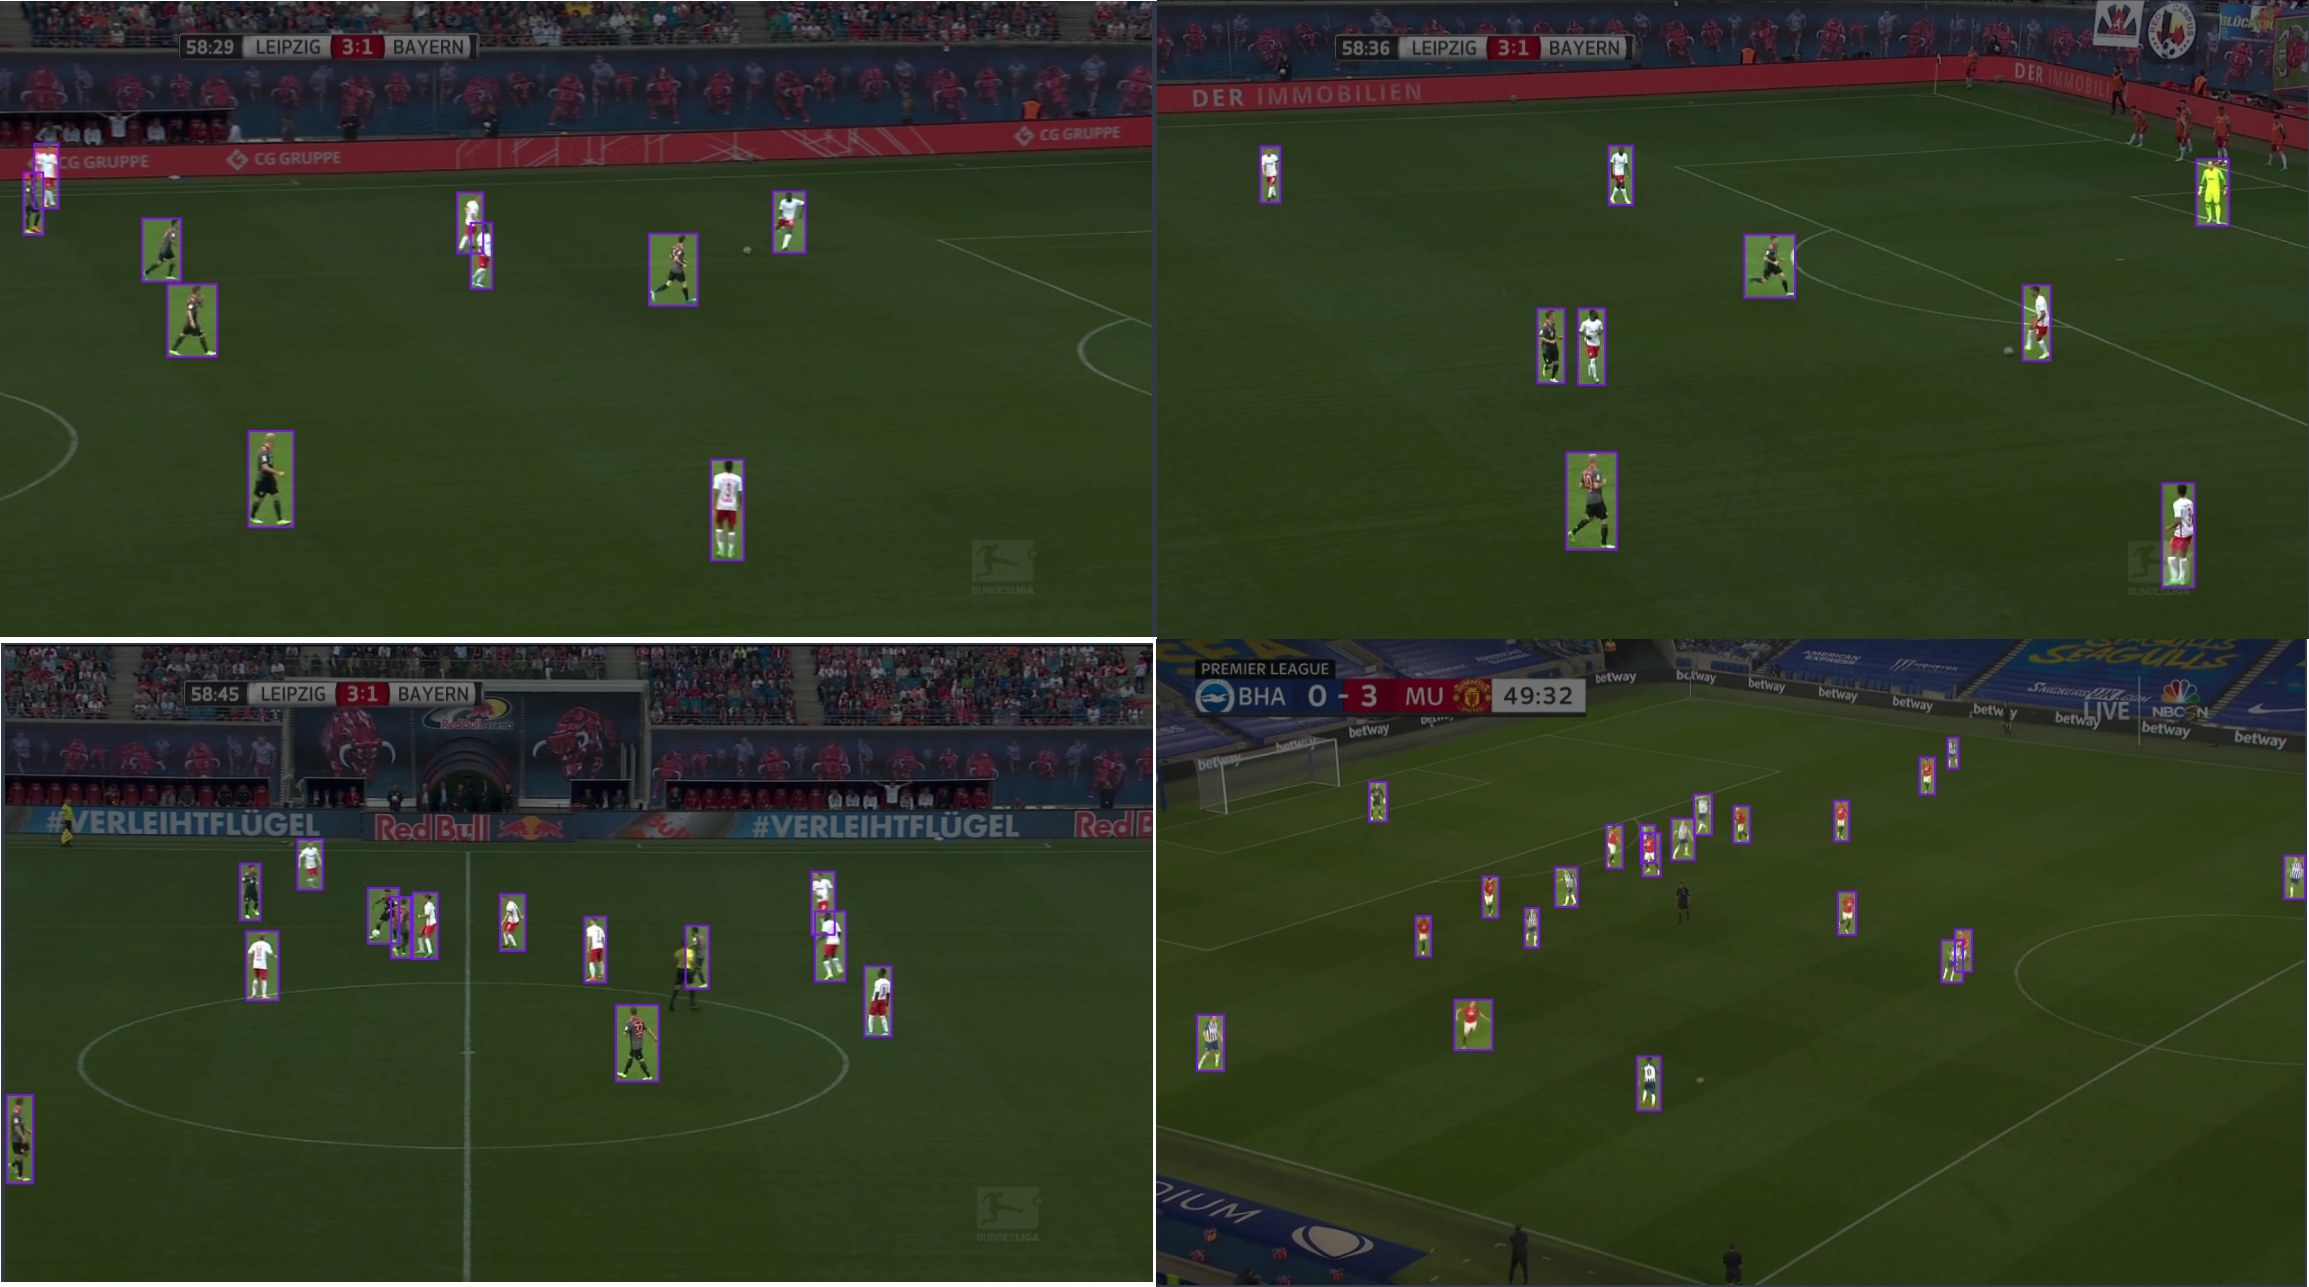

# Model Architecture and Illustration

## Description of Model Architectures
In this section, we present our proposed multi-object tracking framework. As mentioned earlier, our framework consists of two sequential modules: YOLOv8, serving as a multi-object detection algorithm, and ByteTrack, functioning as a tracking and player association algorithm. Subsequent sections will delve into the specifics of each module.


### YOLOv8
Object detection is a popular task in computer vision. It deals with locating an area of interest within an image and classifying that area like a typical image classifier. One of the most popular object detection models known for its speed and accuracy is YOLO (You Only Look Once). It was first introduced by Joseph Redmon et al. in 2015 and has since undergone several variations. YOLO's fame is due to its high accuracy while maintaining small model size. Over time, different versions of YOLO object detection have been introduced. One of the newest and most state-of-the-art modern YOLO variants is YOLOv8, which was recently launched. The main applications of YOLOv8 are object detection, image classification and instance segmentation tasks. YOLOv8 includes numerous architectural changes and improvements in terms of architecture and developer experience changes and improvements over YOLOv5.

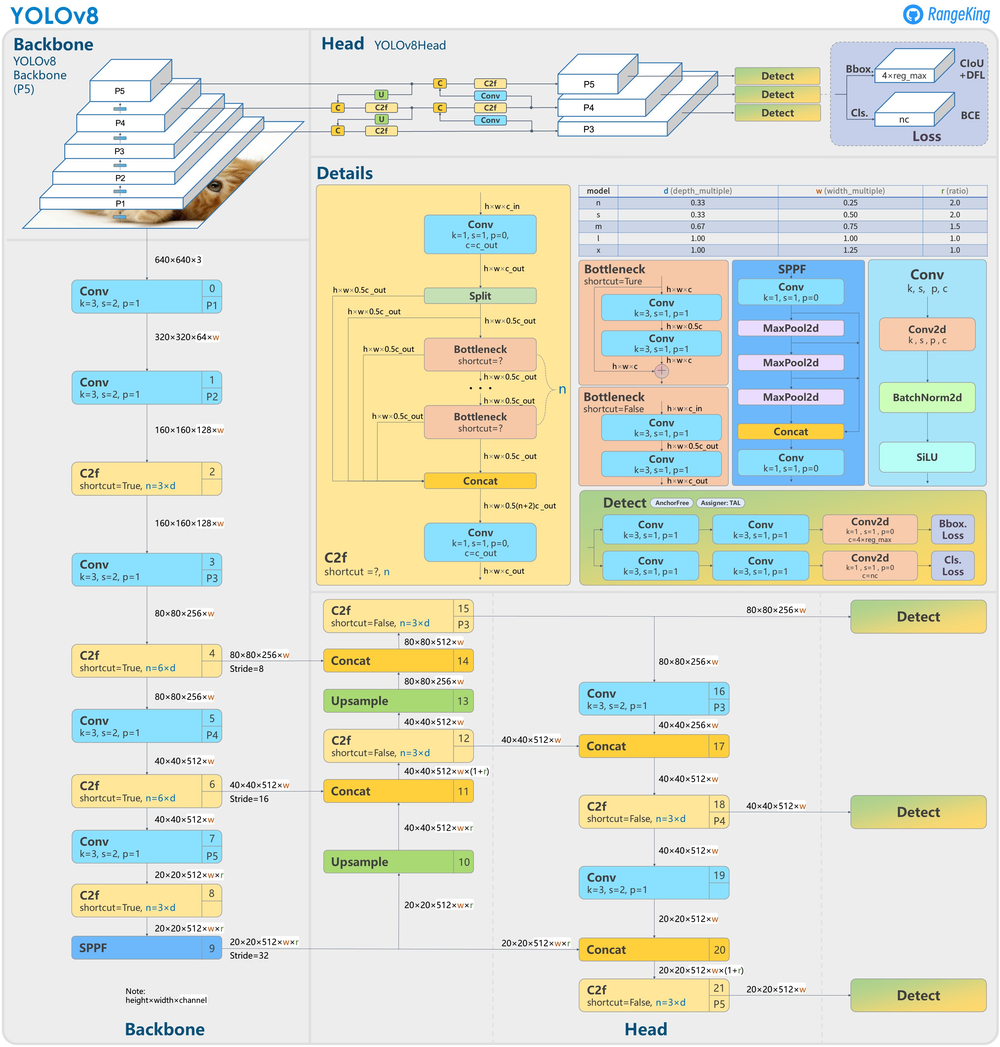
YOLOv8 [4]

Essentially, the YOLO algorithm has the ability to detect and classify multiple objects within an image by predicting their locations. This is achieved through a single-stage process where the image is divided into N grids of size s*s. These grids are analyzed simultaneously to detect and localize objects within them. The model predicts bounding box coordinates (B) for each grid along with a label and prediction score for the detected object. Given that the fundamental technology of YOLO remains unchanged, we can assume that this principle also applies to YOLOv8.

According to the official release, YOLOv8 introduces several advancements including a new backbone network, an anchor-free detection head, and a revised loss function.

YOLOv8 adopts an anchor-free approach, a departure from traditional models that rely on predefined anchor boxes for object detection. Unlike conventional methods that predict the offset from anchor boxes, YOLOv8 directly predicts the center of objects within the image, along with their class labels and confidence scores. This eliminates the need for anchor boxes, resulting in fewer box predictions and faster inference times. Additionally, the absence of anchor boxes simplifies the Non-Maximum Suppression (NMS) process during post-processing, where overlapping bounding boxes are filtered to retain the most confident and accurate detections.

Additionally, the diagram shows that the head of the model now handles classification and regression tasks separately, which helps improve the model's performance.

Regarding loss, when the classification and regression tasks are separated, there's a chance of misalignment, meaning the model might locate one object while identifying another. To address this, a task alignment score is introduced, which helps the model distinguish between positive and negative samples. This score combines the classification score with the Intersection over Union (IoU) score, which indicates how accurate a bounding box prediction is.

Using this alignment score, the model selects the top-k positive samples and calculates the classification loss using Binary Cross-Entropy (BCE) and regression loss using Complete IoU (CIoU) and Distributional Focal Loss (DFL). BCE loss measures the difference between the actual and predicted labels, CIoU loss considers the accuracy of the bounding box in terms of its center point and aspect ratio, and DFL focuses on improving the distribution of bounding box boundaries, particularly on samples that the model misclassifies as false negatives.

The YOLOv8 architecture is an evolution of previous YOLO algorithms, featuring a convolutional neural network divided into two main components: the backbone and the head.

The backbone of YOLOv8 is based on a modified version of the CSPDarknet53 architecture, comprising 53 convolutional layers. It incorporates cross-stage partial connections to enhance information flow between layers.
The head of YOLOv8 includes several convolutional layers followed by fully connected layers. These layers are responsible for predicting bounding boxes, objectness scores, and class probabilities for detected objects.

One notable feature of YOLOv8 is the integration of a self-attention mechanism in the head of the network. This mechanism enables the model to focus on different areas of the image and adjust the importance of features based on their relevance.

Additionally, YOLOv8 excels in multi-scaled object detection by utilizing a feature pyramid network. This network consists of multiple layers designed to detect objects of varying sizes and scales within an image, ensuring the model can detect both large and small objects effectively.



In [ ]:
!pip install -U ultralytics


In [ ]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image

Ultralytics YOLOv8.1.29 🚀 Python-3.8.18 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11264MiB)
Setup complete ✅ (24 CPUs, 127.7 GB RAM, 2713.8/2794.5 GB disk)


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = YOLO("yolov8n.pt")
model = model.to(device)
# dirct_classes = model.model.names
# print(dirct_classes)

In [ ]:
output = model.train(data='data.yaml', epochs=50, batch=32, val = True, imgsz=1280, plots=True, device = [0],
                     optimizer = 'Adam', name = 'bs_32_imgs_1280_nano', save = True)

Ultralytics YOLOv8.1.29 🚀 Python-3.8.18 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11264MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=1280, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=bs_32_imgs_1280_nano, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning D:\LoghmanMoradi\MIE1517_Project\YOLOv8\datasets\train\labels.cache... 7601 images, 10 backgrounds, 0 corrupt: 100%|██████████| 7611/7611 [00:00<?, ?it/s]
val: Scanning D:\LoghmanMoradi\MIE1517_Project\YOLOv8\datasets\val\labels.cache... 988 images, 0 backgrounds, 0 corrupt: 100%|██████████| 988/988 [00:00<?, ?it/s]


Plotting labels to runs\detect\bs_32_imgs_1280_nano\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs\detect\bs_32_imgs_1280_nano
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      18.8G      0.798     0.6597     0.8904        665       1280: 100%|██████████| 238/238 [38:09<00:00,  9.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:52<00:00,  3.31s/it]

                   all        988      13184      0.903      0.879      0.921        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      21.3G     0.7473     0.4592     0.8816        623       1280: 100%|██████████| 238/238 [38:41<00:00,  9.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:04<00:00,  4.00s/it]

                   all        988      13184      0.921      0.927      0.941      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      20.8G     0.7152     0.4291      0.874        575       1280: 100%|██████████| 238/238 [37:46<00:00,  9.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:55<00:00,  3.49s/it]

                   all        988      13184      0.932      0.953      0.958      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      20.1G     0.6951     0.4137     0.8685        641       1280: 100%|██████████| 238/238 [39:01<00:00,  9.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:56<00:00,  3.51s/it]

                   all        988      13184      0.928      0.934      0.951      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      18.7G     0.6842     0.4036     0.8679        623       1280: 100%|██████████| 238/238 [38:49<00:00,  9.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:56<00:00,  3.54s/it]

                   all        988      13184      0.938      0.934      0.955      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      21.6G     0.6578     0.3848     0.8603        575       1280: 100%|██████████| 238/238 [38:11<00:00,  9.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:04<00:00,  4.01s/it]

                   all        988      13184      0.937      0.965      0.974       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      19.8G     0.6462      0.376     0.8565        602       1280: 100%|██████████| 238/238 [37:42<00:00,  9.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:55<00:00,  3.49s/it]

                   all        988      13184      0.951      0.958       0.97      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      20.5G       0.64     0.3693     0.8559        473       1280: 100%|██████████| 238/238 [37:34<00:00,  9.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:56<00:00,  3.54s/it]

                   all        988      13184      0.925      0.959      0.961      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      20.4G     0.6325     0.3639     0.8544        569       1280: 100%|██████████| 238/238 [38:06<00:00,  9.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:02<00:00,  3.89s/it]

                   all        988      13184      0.938      0.942      0.969       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      20.4G     0.6237     0.3572     0.8531        646       1280: 100%|██████████| 238/238 [38:09<00:00,  9.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:03<00:00,  4.00s/it]

                   all        988      13184      0.934      0.962      0.971      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      25.9G     0.6219     0.3532     0.8515        632       1280: 100%|██████████| 238/238 [33:57<00:00,  8.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:56<00:00,  3.51s/it]

                   all        988      13184       0.94      0.957      0.971      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      23.2G     0.6169     0.3482     0.8509        572       1280: 100%|██████████| 238/238 [34:02<00:00,  8.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:55<00:00,  3.50s/it]

                   all        988      13184      0.926       0.94      0.965      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      20.4G     0.6146     0.3497     0.8508        650       1280: 100%|██████████| 238/238 [34:10<00:00,  8.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:58<00:00,  3.66s/it]

                   all        988      13184      0.938       0.96      0.976      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      20.1G     0.6079      0.342     0.8493        619       1280: 100%|██████████| 238/238 [39:11<00:00,  9.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:55<00:00,  3.49s/it]

                   all        988      13184      0.941      0.964      0.966      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50        23G     0.6054     0.3385     0.8479        639       1280: 100%|██████████| 238/238 [38:14<00:00,  9.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:03<00:00,  3.99s/it]

                   all        988      13184      0.935      0.954      0.969      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      19.6G     0.6066     0.3401     0.8493        590       1280: 100%|██████████| 238/238 [38:03<00:00,  9.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:55<00:00,  3.50s/it]

                   all        988      13184      0.927      0.956      0.966      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      21.1G     0.5984     0.3341      0.847        682       1280: 100%|██████████| 238/238 [39:29<00:00,  9.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:55<00:00,  3.50s/it]

                   all        988      13184      0.938      0.977      0.976      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50        20G     0.5934     0.3316     0.8464        594       1280: 100%|██████████| 238/238 [33:49<00:00,  8.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:56<00:00,  3.52s/it]

                   all        988      13184      0.936      0.944       0.96      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      21.6G     0.5956     0.3296     0.8453        609       1280: 100%|██████████| 238/238 [38:23<00:00,  9.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:55<00:00,  3.48s/it]

                   all        988      13184      0.947      0.972      0.977      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      18.8G     0.5909     0.3267     0.8448        594       1280: 100%|██████████| 238/238 [37:26<00:00,  9.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:56<00:00,  3.51s/it]

                   all        988      13184      0.936      0.972      0.977      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      20.7G     0.5903     0.3277     0.8452        773       1280: 100%|██████████| 238/238 [37:23<00:00,  9.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:56<00:00,  3.54s/it]

                   all        988      13184      0.938      0.965      0.975      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      22.1G      0.589     0.3231     0.8445        589       1280: 100%|██████████| 238/238 [34:16<00:00,  8.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:02<00:00,  3.89s/it]

                   all        988      13184      0.924      0.968      0.969      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50        20G     0.5883     0.3219     0.8442        772       1280: 100%|██████████| 238/238 [35:00<00:00,  8.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:59<00:00,  3.75s/it]

                   all        988      13184      0.947      0.968      0.972      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      21.9G     0.5843     0.3217     0.8449        721       1280: 100%|██████████| 238/238 [38:59<00:00,  9.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:56<00:00,  3.53s/it]

                   all        988      13184      0.938      0.973      0.975      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      19.3G     0.5797     0.3158     0.8419        677       1280: 100%|██████████| 238/238 [39:10<00:00,  9.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:54<00:00,  3.41s/it]

                   all        988      13184      0.942      0.964      0.971      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      20.6G     0.5767     0.3116     0.8411        584       1280: 100%|██████████| 238/238 [37:46<00:00,  9.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:55<00:00,  3.46s/it]

                   all        988      13184      0.939      0.962      0.979       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      21.4G     0.5789      0.314     0.8423        600       1280: 100%|██████████| 238/238 [41:06<00:00, 10.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:01<00:00,  3.85s/it]

                   all        988      13184      0.934      0.964      0.973      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      21.2G     0.5742     0.3096     0.8418        667       1280: 100%|██████████| 238/238 [42:26<00:00, 10.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:03<00:00,  3.99s/it]

                   all        988      13184      0.946      0.978      0.979      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      21.3G      0.572     0.3092     0.8398        574       1280: 100%|██████████| 238/238 [42:23<00:00, 10.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:01<00:00,  3.85s/it]

                   all        988      13184      0.943      0.975      0.979      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      22.4G     0.5715     0.3082     0.8403        634       1280: 100%|██████████| 238/238 [41:00<00:00, 10.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:02<00:00,  3.90s/it]

                   all        988      13184      0.934      0.966      0.977      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      23.3G     0.5658      0.304     0.8392        535       1280: 100%|██████████| 238/238 [41:16<00:00, 10.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:07<00:00,  4.21s/it]

                   all        988      13184      0.944      0.973       0.98      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      21.3G     0.5659     0.3022     0.8384        559       1280: 100%|██████████| 238/238 [41:24<00:00, 10.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:10<00:00,  4.39s/it]

                   all        988      13184      0.945      0.964      0.977      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50        21G     0.5619     0.3009     0.8388        568       1280: 100%|██████████| 238/238 [42:50<00:00, 10.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:00<00:00,  3.76s/it]

                   all        988      13184      0.929      0.966      0.971       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50        19G     0.5592     0.2955     0.8364        667       1280: 100%|██████████| 238/238 [41:45<00:00, 10.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:59<00:00,  3.71s/it]

                   all        988      13184      0.944      0.974       0.98       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      20.4G     0.5601     0.2929     0.8362        710       1280: 100%|██████████| 238/238 [42:00<00:00, 10.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:00<00:00,  3.81s/it]

                   all        988      13184      0.938      0.978       0.98      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      21.7G     0.5561     0.2918     0.8365        499       1280: 100%|██████████| 238/238 [40:58<00:00, 10.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:01<00:00,  3.86s/it]

                   all        988      13184      0.938      0.963      0.976      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      21.9G     0.5579     0.2933      0.836        561       1280: 100%|██████████| 238/238 [40:49<00:00, 10.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:59<00:00,  3.74s/it]

                   all        988      13184      0.946      0.971      0.978       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      19.2G     0.5501      0.287     0.8347        610       1280: 100%|██████████| 238/238 [36:52<00:00,  9.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:02<00:00,  3.88s/it]

                   all        988      13184      0.938      0.973      0.977      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      18.5G     0.5477     0.2838     0.8349        669       1280: 100%|██████████| 238/238 [41:58<00:00, 10.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:01<00:00,  3.85s/it]

                   all        988      13184       0.94      0.966      0.973      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      20.9G     0.5488     0.2834     0.8362        614       1280: 100%|██████████| 238/238 [38:57<00:00,  9.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:56<00:00,  3.56s/it]

                   all        988      13184      0.936      0.974      0.978      0.847


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      17.5G     0.5257     0.2776     0.8291        312       1280: 100%|██████████| 238/238 [34:59<00:00,  8.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:59<00:00,  3.72s/it]

                   all        988      13184      0.934      0.979      0.978      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      17.2G     0.5208     0.2723     0.8258        319       1280: 100%|██████████| 238/238 [36:37<00:00,  9.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:59<00:00,  3.71s/it]

                   all        988      13184      0.936      0.974      0.975      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      17.5G      0.516      0.266     0.8263        313       1280: 100%|██████████| 238/238 [34:57<00:00,  8.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:59<00:00,  3.71s/it]

                   all        988      13184      0.942      0.973      0.978      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      17.5G     0.5139     0.2647     0.8241        312       1280: 100%|██████████| 238/238 [33:23<00:00,  8.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:57<00:00,  3.62s/it]

                   all        988      13184      0.944      0.978       0.98      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      17.5G     0.5088     0.2594      0.824        326       1280: 100%|██████████| 238/238 [34:54<00:00,  8.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:59<00:00,  3.72s/it]

                   all        988      13184      0.939      0.971      0.975      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      17.2G     0.5012     0.2545     0.8218        288       1280: 100%|██████████| 238/238 [36:32<00:00,  9.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:59<00:00,  3.71s/it]

                   all        988      13184       0.94      0.976      0.977      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      17.3G     0.4992     0.2501     0.8214        338       1280: 100%|██████████| 238/238 [34:07<00:00,  8.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:58<00:00,  3.63s/it]

                   all        988      13184      0.939      0.973      0.976      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      17.5G     0.4944     0.2458     0.8205        342       1280: 100%|██████████| 238/238 [34:54<00:00,  8.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:59<00:00,  3.73s/it]

                   all        988      13184      0.942      0.977      0.979      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      17.2G     0.4923     0.2412     0.8199        334       1280: 100%|██████████| 238/238 [36:29<00:00,  9.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [01:01<00:00,  3.84s/it]

                   all        988      13184      0.942      0.972      0.976      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      17.2G     0.4868     0.2365     0.8171        319       1280: 100%|██████████| 238/238 [36:37<00:00,  9.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:59<00:00,  3.71s/it]

                   all        988      13184      0.941      0.975      0.978      0.856



50 epochs completed in 32.551 hours.
Optimizer stripped from runs\detect\bs_32_imgs_1280_nano\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\bs_32_imgs_1280_nano\weights\best.pt, 6.3MB

Validating runs\detect\bs_32_imgs_1280_nano\weights\best.pt...
Ultralytics YOLOv8.1.29 🚀 Python-3.8.18 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11264MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        988      13184      0.944      0.974       0.98       0.86
Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\bs_32_imgs_1280_nano


### ByteTrack
To enhance the performance and robustness of the detection algorithm, ByteTrack object tracking and association are employed. After the detection stage, ByteTrack categorizes detected bounding boxes into high-confidence, low-confidence, and background boxes based on predetermined thresholds. Background boxes are discarded, while both high and low-confidence boxes are retained for subsequent association stages.
In the first association stage, high-confidence detection boxes from the current frame are matched with predicted boxes from previous frame tracklets (using techniques like Kalman filtering). This matching process involves assessing the similarity using IoU scores or feature embeddings (extracted by algorithms like DeepSORT or QDTrack) and employing algorithms like the Hungarian algorithm or matching cascade on Nearest Neighbor Distance. Matches are confirmed only if the score exceeds a predefined threshold. Unmatched high-confidence detection boxes are first paired with tracklets updated from a single frame before being assigned to new tracklets.
In the second association stage, low-confidence detection boxes are matched with the remaining unmatched predicted boxes from previous frames. Although the matching algorithm remains the same, the threshold is set lower than in the first stage, as occluded boxes are expected to have poorer matches. Unmatched predicted boxes become lost tracklets, while unmatched detection boxes are discarded. Lost tracklets are retained for a specified number of frames and reintroduced as active tracklets before Kalman filter prediction, enabling the recovery of tracklets lost due to temporary object disappearance.

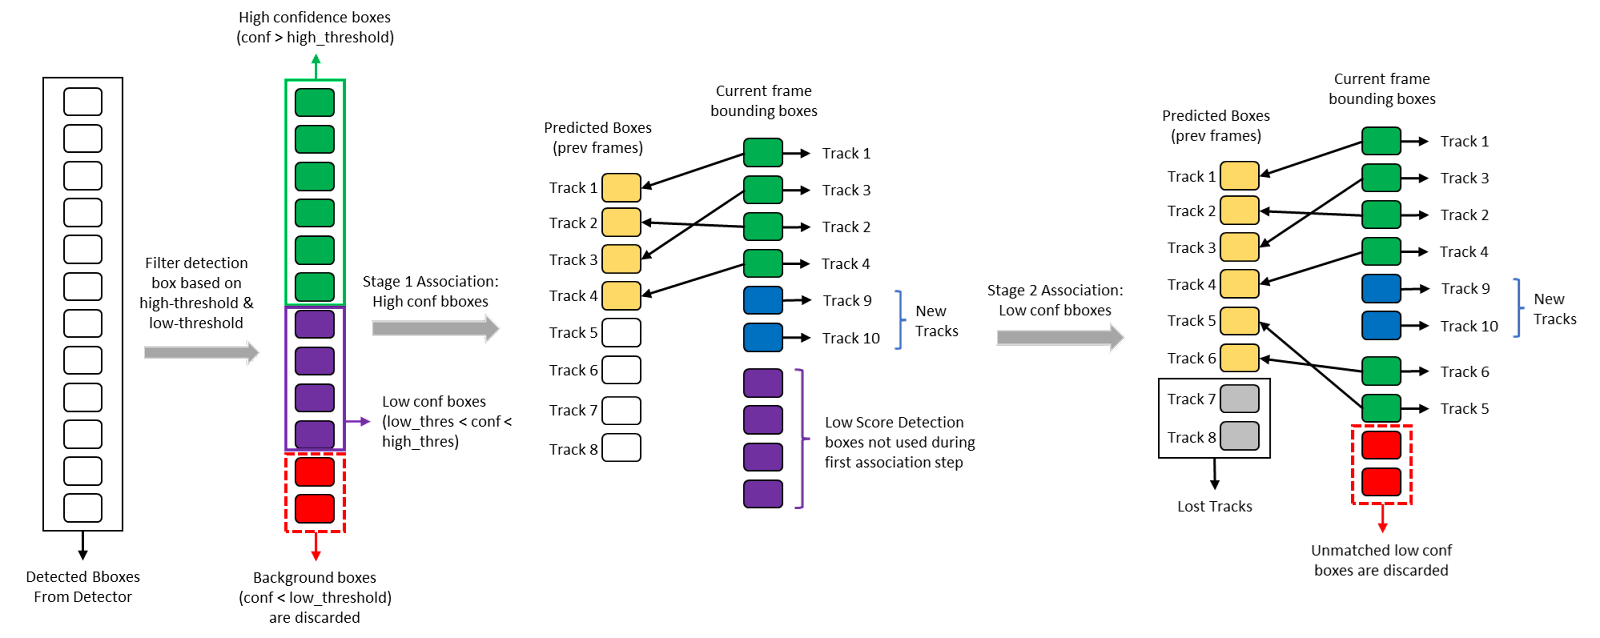
ByteTrack algorithm [5]

In [ ]:
!git clone https://github.com/roboflow/supervision.git
%cd ./supervision/examples/traffic_analysis
%cd ./supervision/examples/traffic_analysis
!pip install -r requirements.txt

In [ ]:
best_model_dir = "D:\\LoghmanMoradi\\MIE1517_Project\\YOLOv8\\runs\\detect\\train3\weights\\best.pt"
model = YOLO(best_model_dir)

import cv2
import numpy as np
import supervision.supervision as sv
from ultralytics import YOLO
#from google.colab.patches import cv2_imshow

COLORS = sv.ColorPalette.default()
POSITION = sv.Position.BOTTOM_LEFT

class VideoProcessor:
  def __init__(
      self,
      source_weight_path: str,
      source_video_path: str,
      target_video_path: str,
      confidence_threshold: float = 0.3,
      iou_threshold: float = 0.7,
  ) -> None:
    self.source_weight_path = source_weight_path
    self.source_video_path = source_video_path
    self.target_video_path = target_video_path
    self.confidence_threshold = confidence_threshold
    self.iou = iou_threshold

    self.model = YOLO(source_weight_path)
    self.tracker = sv.ByteTrack()
    self.box_annotator = sv.EllipseAnnotator(color=COLORS)
    self.label_annotator = sv.LabelAnnotator(text_position=POSITION,
                                             text_padding=5)

  def process_video(self):
    video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
    frame_generator = sv.get_video_frames_generator(
        source_path=self.source_video_path)

    with sv.VideoSink(self.target_video_path, video_info) as sink:
      for frame in frame_generator:
        processed_frame = self.process_frame(frame=frame)

        sink.write_frame(processed_frame)

    # frame_generator = sv.get_video_frames_generator(
    #     source_path=self.source_video_path)

    # for frame in frame_generator:
    #   processed_frame = self.process_frame(frame=frame)
    #   cv2_imshow( processed_frame)
    #   if cv2.waitKey(1) & 0xFF == ord("q"):
    #     break

    # cv2.destroyAllWindows()

  def annotate_frame(
      self, frame:np.ndarray, detections: sv.Detections
  ) -> np.ndarray:
    annotated_frame = frame.copy()
    labels = [
          f"#{tracker_id}"
          for tracker_id in detections.tracker_id
    ]
    annotated_frame = self.box_annotator.annotate(
        scene=annotated_frame, detections=detections
    )
    labeled_frame = self.label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels
    )
    return labeled_frame

  def process_frame(self, frame: np.ndarray) -> np.ndarray:
    result = self.model(
        frame, verbose=False, conf=self.confidence_threshold,
        iou=self.iou
    )[0]
    detections = sv.Detections.from_ultralytics(result)
    detections = self.tracker.update_with_detections(detections)
    annotated_frame = self.annotate_frame(frame=frame,
                                          detections=detections)

    return annotated_frame



In [ ]:
TARGET_VIDEO = 'clip_target_video.mp4'
SOURCE_VIDEO = 'clips/08fd33_2.mp4'
processor = VideoProcessor(
    source_weight_path=best_model_dir,
    source_video_path=SOURCE_VIDEO,
    target_video_path=TARGET_VIDEO,
    confidence_threshold=0.3,
    iou_threshold=0.7
)
processor.process_video()

### Experiments and results
To evaluate the performance of our proposed method, we followed the approach outlined earlier by separating soccer data from the entire dataset and utilizing it for training, validation, and testing purposes. We employed two distinct YOLOv8 models, namely nano and medium. These models were trained using input images resized to 1280x1280 pixels, with batch sizes of 32 and 16, and a learning rate set to 0.01 using the Adam optimizer. The experiments were conducted on a system equipped with an Intel Core i7 CPU and a GeForce RTX 2080 GPU.

Upon analyzing the loss curves for bounding boxes and classification, along with the recall and mAP50-95 curves depicted below, we observed that the performance of the medium model slightly surpassed that of the other two models. Consequently, we have decided to proceed with using the medium model as our final choice.

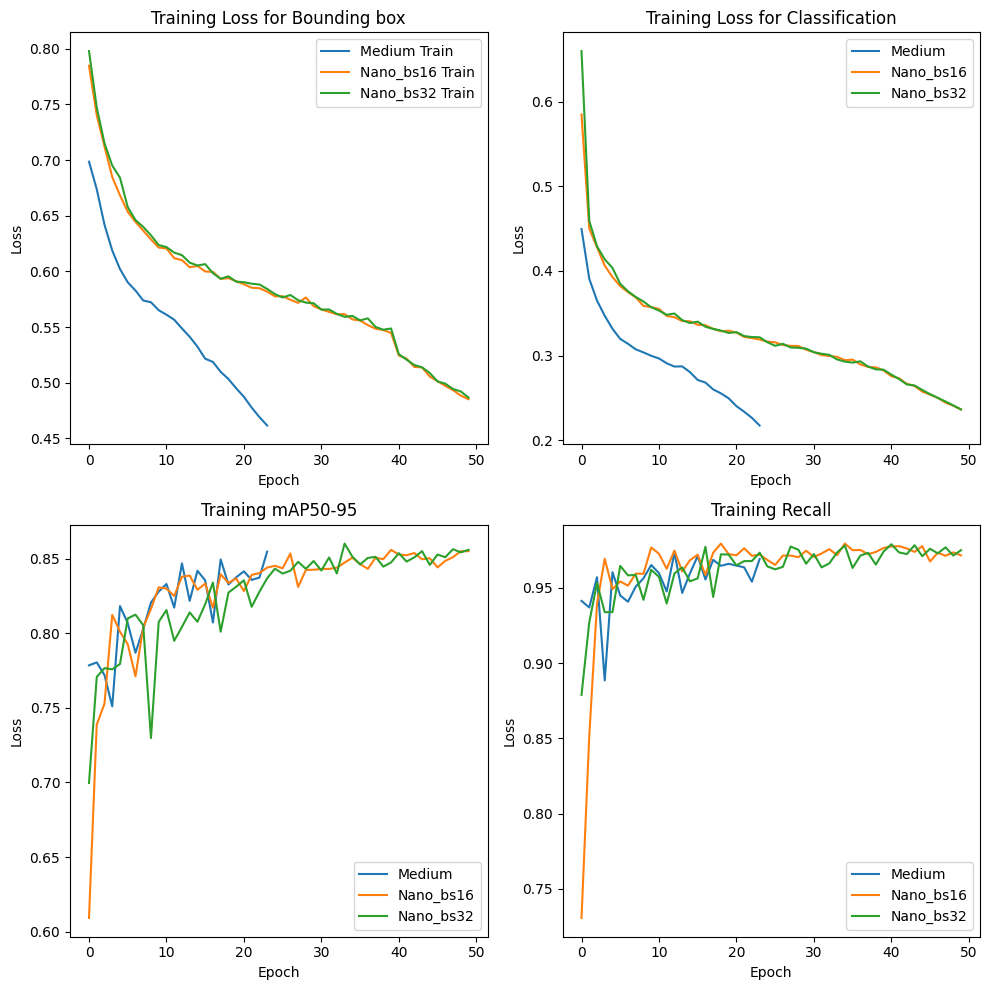

In [ ]:
# Load the CSV files
import pandas as pd
import matplotlib.pyplot as plt

medium = pd.read_csv("/content/drive/MyDrive/A_project_yolov8/progress_report/Final Results/bs_16_imgs_1280_medium/results.csv")
nano16 = pd.read_csv("/content/drive/MyDrive/A_project_yolov8/progress_report/Final Results/bs_16_imgs_1280_nano/results.csv")
nano32 = pd.read_csv("/content/drive/MyDrive/A_project_yolov8/progress_report/Final Results/bs_32_imgs_1280_nano/results.csv")

# Extract one item from each file (replace 'item_name' with the column name)
medium_loss_train = medium['         train/box_loss']
nano16_loss_train = nano16['         train/box_loss']
nano32_loss_train = nano32['         train/box_loss']
# Plot the items
plt.figure(figsize=(10, 10))

# Plot item from the first file
plt.subplot(221)
plt.plot(medium_loss_train)
plt.plot(nano16_loss_train)
plt.plot(nano32_loss_train)
plt.title('Training Loss for Bounding box')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Medium Train', 'Nano_bs16 Train', 'Nano_bs32 Train'])

medium_cls_loss_train = medium['         train/cls_loss']
nano16_csl_loss_train = nano16['         train/cls_loss']
nano32_csl_loss_train = nano32['         train/cls_loss']
# Plot item from the first file
plt.subplot(222)
plt.plot(medium_cls_loss_train)
plt.plot(nano16_csl_loss_train)
plt.plot(nano32_csl_loss_train)
plt.title('Training Loss for Classification')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Medium', 'Nano_bs16', 'Nano_bs32'])
####
medium_mAP_train = medium['    metrics/mAP50-95(B)']
nano16_mAP_train = nano16['    metrics/mAP50-95(B)']
nano32_mAP_train = nano32['    metrics/mAP50-95(B)']
# Plot item from the first file
plt.subplot(223)
plt.plot(medium_mAP_train)
plt.plot(nano16_mAP_train)
plt.plot(nano32_mAP_train)
plt.title('Training mAP50-95')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Medium', 'Nano_bs16', 'Nano_bs32'])

####
####
medium_mAP_train = medium['      metrics/recall(B)']
nano16_mAP_train = nano16['      metrics/recall(B)']
nano32_mAP_train = nano32['      metrics/recall(B)']
# Plot item from the first file
plt.subplot(224)
plt.plot(medium_mAP_train)
plt.plot(nano16_mAP_train)
plt.plot(nano32_mAP_train)
plt.title('Training Recall')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Medium', 'Nano_bs16', 'Nano_bs32'])


plt.tight_layout()
plt.show()

## Quantitative  Results
The effectiveness of our approach is assessed through a comprehensive quantitative analysis, where we examine several crucial performance metrics and confusion matrix to evaluate the model's performance.

The figure below illustrates several key curves, encompassing bounding box detection loss, classification loss, distributional focal loss, precision, and recall for both the training and validation datasets. Notably, all loss curves exhibit a descending trend, indicative of the model's appropriate learning trajectory. However, it is observed that the model does not converge to an optimal point, suggesting the need for further training time. Due to time constraints and the computational expense associated with prolonged training, we elected to limit the training duration to a specific number of epochs. Despite this limitation, the precision, recall, mAP50, and mAP50-95 curves for both training and validation datasets demonstrate promising results. Examining the precision curve reveals that the model achieves a precision rate of approximately 94% in the final epochs.Moreover, the mAP50-95 curve, which assesses the model's performance across a range of thresholds and provides insight into the model's consistency in detecting objects with varying levels of confidence. The upward trend observed in the mAP50-95 curve underscores the model's effectiveness in accurately localizing and classifying objects across a wide range of conditions, further affirming its robustness and reliability.

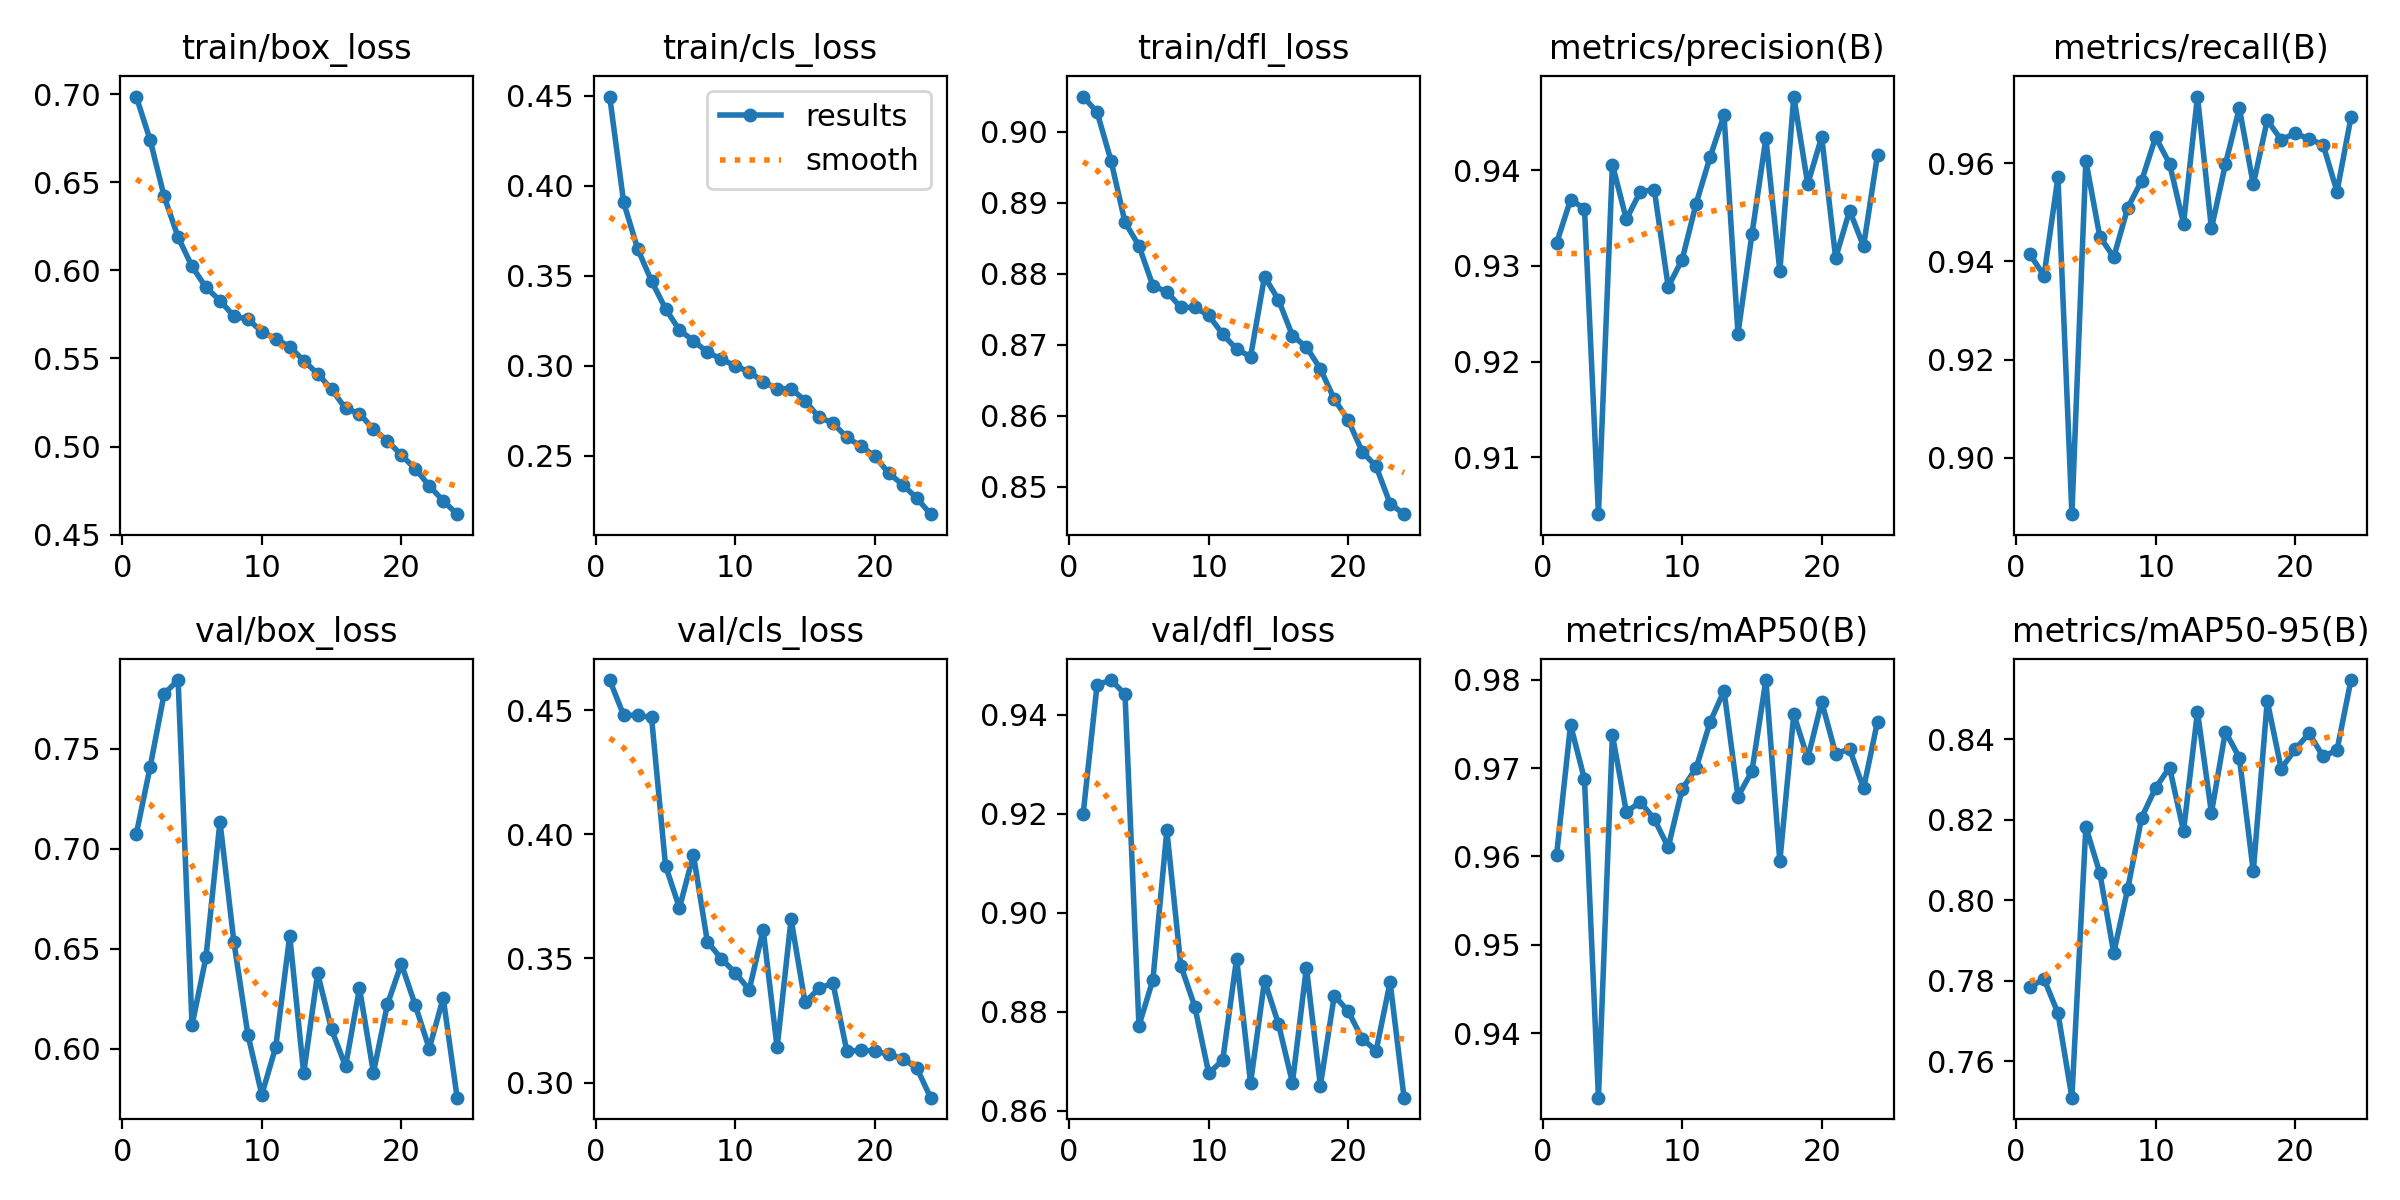

Additionally, the following confusion matrix illustrates the model's performance during training. It is evident from the matrix that the model is able to accurately distinguish between players and background with high precision.

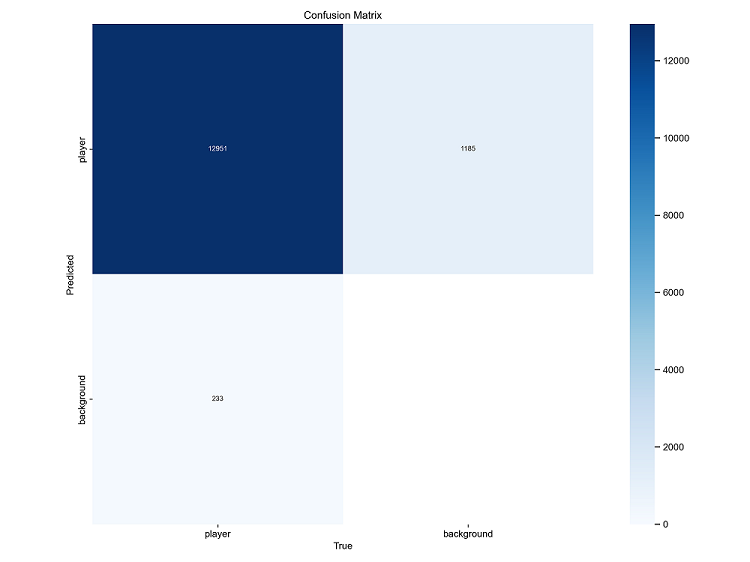

## Qualitative  Results

For evaluating the qualitative performance of our model, a series of random videos were inputted into the trained model, and the outcomes were examined. The following figure illustrates the qualitative results of our proposed system for sports player detection and tracking. Upon closer examination of the images, it is evident that the model performs well in detecting different players across consecutive frames. Its primary strength lies in its ability to accurately detect players in densely populated areas where there is significant overlap between individuals. However, one notable issue with the proposed model arises in its occasional misclassification of referees and coaches outside the playing field as players.

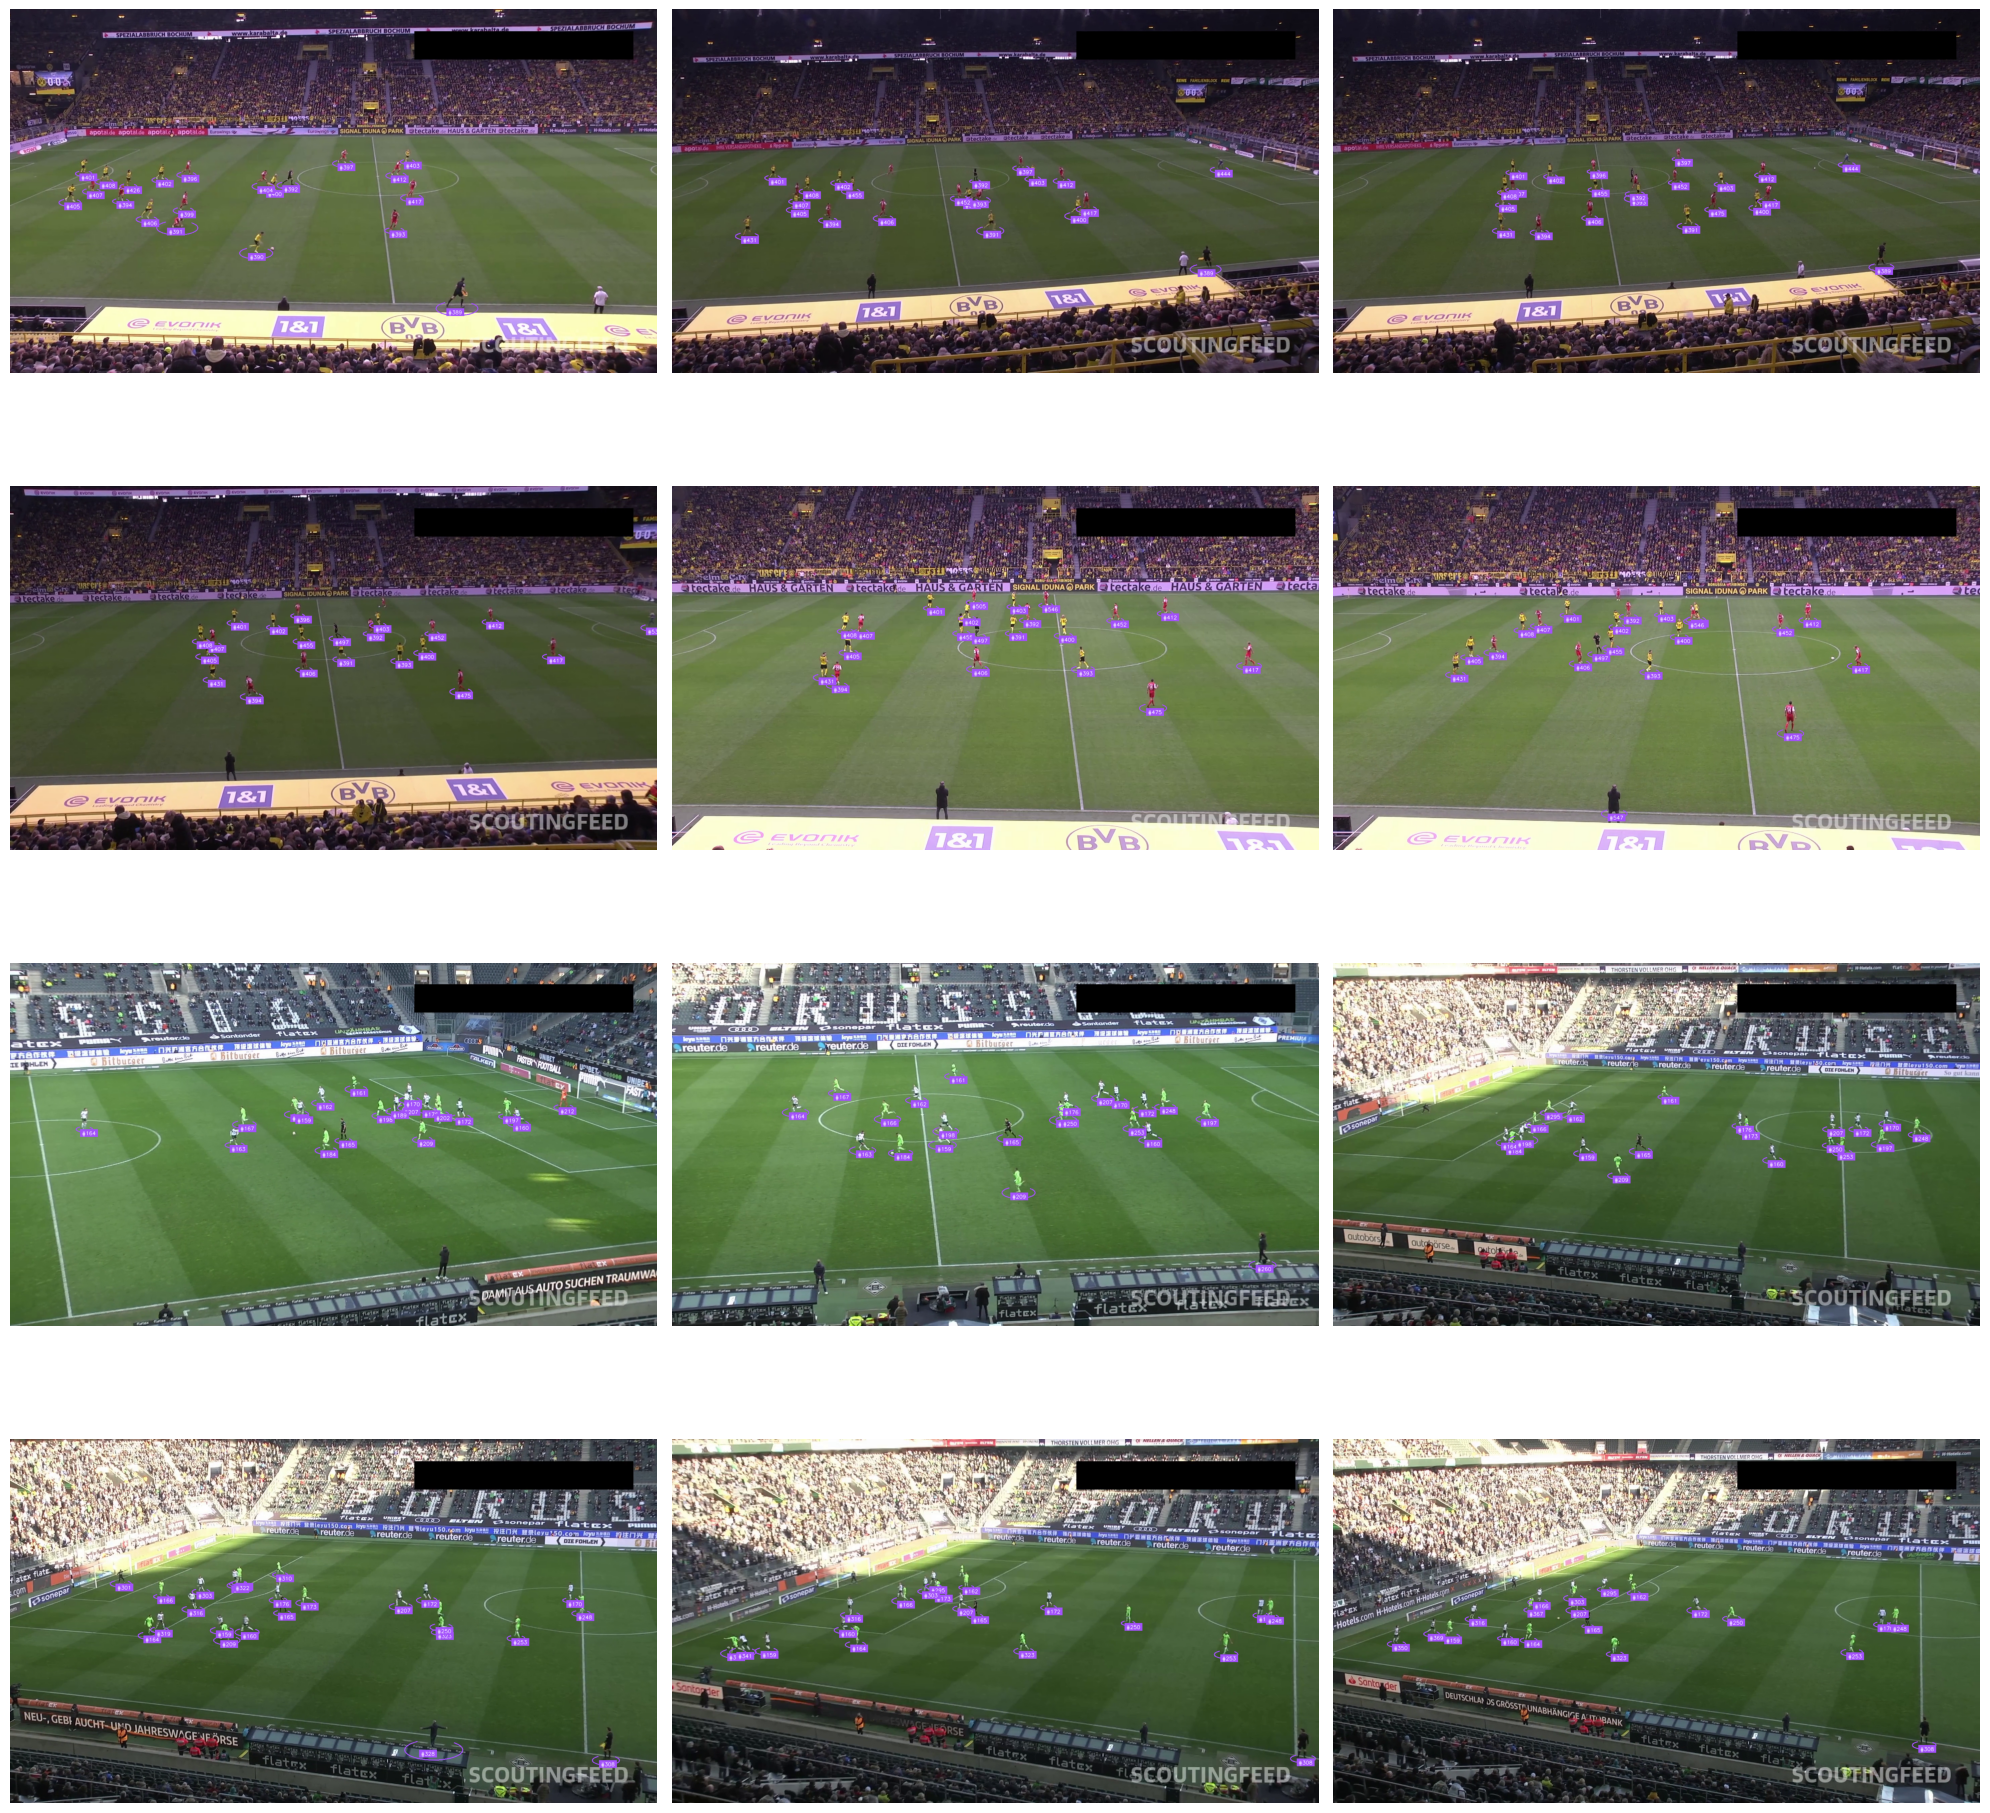

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

frames_dir = f"{HOME}/frames_results"
images = []
for folder in os.listdir(frames_dir):
    folder_path = os.path.join(frames_dir, folder)
    for file in os.listdir(folder_path):
        if file.endswith(".png"):
            image = Image.open(os.path.join(folder_path, file))
            images.append(image)

def display_imgs(imges, rows=4, cols=3):
    fig,axes = plt.subplots(rows, cols, figsize=(20, 20))
    for ax, img in zip(axes.flatten(), imges):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

display_imgs(images)

# Discussion
In this project, our focus was on developing a multi-object detection and tracking system that combines YOLOv8 for object detection and ByteTrack for tracking and player association. Our experimental findings demonstrate the effectiveness of this model in achieving its objectives, despite some identified deficiencies.

One of the key challenges in multi-object tracking (MOT) within the sports domain lies in accurately detecting and tracking players, particularly in scenarios characterized by increasing speeds and crowded environments. Our results indicate that the model effectively addresses these challenges, successfully detecting players in crowded areas and tracking them during fast transitions.

Comparison with existing frameworks such as SportsMOT and SoccerNet-Tracking reveals that our model achieves comparable results, showcasing its efficacy. However, one notable drawback of our model is its computational complexity, which warrants attention.

# Conclusion
In conclusion, our study centered on the development of a multi-object detection and tracking system utilizing YOLOv8 for object detection and ByteTrack for tracking and player association, yielding promising results. As a suggestion for future enhancements, assigning fixed IDs to players and classifying players from different teams could offer valuable insights. Additionally, improving the accuracy of the model and filtering out irrelevant objects can enhance the overall performance of the system.

# Citations and References

### Refereence
[1] Patrick Dendorfer, Hamid Rezatofighi, Anton Milan, Javen Shi, Daniel Cremers, Ian Reid, Stefan Roth, Konrad Schindler, and Laura Leal-Taixé. Mot20: A benchmark for multi object tracking in crowded scenes. arXiv preprint arXiv:2003.09003, 2020.

[2] Peize Sun, Jinkun Cao, Yi Jiang, Zehuan Yuan, Song Bai, Kris Kitani, and Ping Luo. Dancetrack: Multi-object tracking in uniform appearance and diverse motion. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pages 20993–21002, 2022. 1, 3

[3] Andreas Geiger, Philip Lenz, and Raquel Urtasun. Are we ready for autonomous driving? the kitti vision benchmark suite. In 2012 IEEE conference on computer vision and pattern recognition, pages 3354–3361. IEEE, 2012. 1, 3

[4] What is YOLOv8? The Ultimate Guide.(https://blog.roboflow.com/whats-new-in-yolov8)

[5] An Introduction to BYTETrack: Multi-Object Tracking by Associating Every Detection Box (https://www.datature.io/blog/introduction-to-bytetrack-multi-object-tracking-by-associating-every-detection-box)

In [2]:
%%shell
jupyter nbconvert --to html /content/Final_Report_Team_9.ipynb

[NbConvertApp] Converting notebook /content/Final_Report_Team_9.ipynb to html
[NbConvertApp] Writing 9569695 bytes to /content/Final_Report_Team_9.html
